In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_796.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_821.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_830.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_798.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_824.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_819.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_802.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_810.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_811.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons/Polygon_841.geojson


In [2]:
pip install rastervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from rastervision.core.data import RasterioSource,VectorSource,RasterioCRSTransformer,GeoJSONVectorSource,ClassInferenceTransformer,ObjectDetectionLabelSource
from rastervision.core.data import ClassConfig,Scene
from rastervision.pytorch_learner import ObjectDetectionSlidingWindowGeoDataset,ObjectDetectionModelConfig,ObjectDetectionVisualizer,ObjectDetectionRandomWindowGeoDataset
import albumentations as A
from rastervision.pytorch_learner import SolverConfig,ObjectDetectionLearnerConfig,ObjectDetectionGeoDataConfig,ObjectDetectionLearner
from torch.utils.data import ConcatDataset
from rastervision.core.data import MinMaxTransformer
from rastervision.pytorch_learner.learner_config import Backbone

class_config = ClassConfig(names=['Untitled Polygon'], colors=['red'])


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import os
from glob import glob

# Directories containing the images and labels
train_image_dir = r"/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geotiffs"
train_label_dir = r"/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Train_Geojsons"

# Get lists of all GeoTIFF and GeoJSON files
train_image_files = glob(os.path.join(train_image_dir, "*.tif"))
train_label_files = glob(os.path.join(train_label_dir, "*.geojson"))

# Match files based on common patterns in their names
train_image_uris = []
train_label_uris = []

# Extract file names without extensions to pair images and labels
train_image_names = {os.path.splitext(os.path.basename(f))[0]: f for f in train_image_files}
train_label_names = {os.path.splitext(os.path.basename(f))[0]: f for f in train_label_files}

# Match images and labels
for name, image_path in train_image_names.items():
    if name in train_label_names:  # Ensure there is a matching label
        train_image_uris.append(image_path)
        train_label_uris.append(train_label_names[name])
data_augmentation_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
    #A.GaussianBlur(p=0.2),
    #A.HueSaturationValue(p=0.2),
    
])

In [5]:
import os
from glob import glob

# Directories containing the images and labels
val_image_dir = r"/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs"
val_label_dir = r"/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons"

# Get lists of all GeoTIFF and GeoJSON files
val_image_files = glob(os.path.join(val_image_dir, "*.tif"))
val_label_files = glob(os.path.join(val_label_dir, "*.geojson"))

# Match files based on common patterns in their names
val_image_uris = []
val_label_uris = []

# Extract file names without extensions to pair images and labels
val_image_names = {os.path.splitext(os.path.basename(f))[0]: f for f in val_image_files}
val_label_names = {os.path.splitext(os.path.basename(f))[0]: f for f in val_label_files}

# Match images and labels
for name, image_path in val_image_names.items():
    if name in val_label_names:  # Ensure there is a matching label
        val_image_uris.append(image_path)
        val_label_uris.append(val_label_names[name])

In [6]:
for val_image_uri, val_label_uri in zip(val_image_uris, val_label_uris):
    print(val_image_uri)
    print(val_label_uri)

/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_858.tif
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons/Polygon_858.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_860.tif
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons/Polygon_860.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_852.tif
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons/Polygon_852.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_855.tif
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons/Polygon_855.geojson
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_864.tif
/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geojsons/Polygon_864.geojson
/kaggle/input/construction-detection-ras

In [7]:
train_datasets = []

for train_image_uri, train_label_uri in zip(train_image_uris, train_label_uris):
    train_dataset = ObjectDetectionRandomWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=train_image_uri,
        label_vector_uri=train_label_uri,
        label_vector_default_class_id=class_config.get_class_id('Untitled Polygon'),
        size_lims=(960, 1000),
        max_windows=21,
        out_size=896,
        neg_ratio=None,
        ioa_thresh=0.2,
        neg_ioa_thresh=0.199,
        clip=True,
        padding=20,
        transform=data_augmentation_transform
        
    
    )
    train_datasets.append(train_dataset)

train_data = ConcatDataset(train_datasets)

print(len(train_data))  # This will print the total number of samples in the concatenated dataset.


1218


In [8]:
train_image_uris = train_image_uris[:15]
train_label_uris = train_label_uris[:15]
same_train=[]
for train_image_uri, train_label_uri in zip(train_image_uris, train_label_uris):
    trains_dataset = ObjectDetectionSlidingWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=train_image_uri,
        label_vector_uri=train_label_uri,
        size=896,
        stride=896,
        label_vector_default_class_id=class_config.get_class_id('Untitled Polygon'),
        #transform=transform,
        # aoi_uri=aoi_uri,
    )
    same_train.append(trains_dataset)

training_data_as_val = ConcatDataset(same_train)

print(len(training_data_as_val))

2567


In [9]:
val_image_uris = val_image_uris[:8]
val_label_uris = val_label_uris[:8]
val_datasets = []
for val_image_uri, val_label_uri in zip(val_image_uris, val_label_uris):
    val_dataset = ObjectDetectionSlidingWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=val_image_uri,
        label_vector_uri=val_label_uri,
        size=896,
        stride=896,
        label_vector_default_class_id=class_config.get_class_id('Untitled Polygon'),
        # transform=transform,
        # aoi_uri=aoi_uri,
    )
    val_datasets.append(val_dataset)

val_data = ConcatDataset(val_datasets)

print(len(val_data))  # This will print the total number of samples in the concatenated dataset.

660


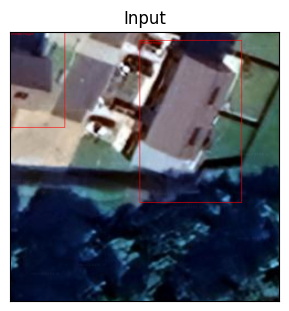

In [10]:
x,y=train_data[30]
x.max()

viz=ObjectDetectionVisualizer(class_names=class_config.names,class_colors=class_config.colors)
viz.plot_batch(x.unsqueeze(0), [y], show=True)

In [11]:
x.shape

torch.Size([3, 896, 896])

In [12]:
import multiprocessing

num_workers = multiprocessing.cpu_count()
print(f"Number of available workers (CPU cores): {num_workers}")


Number of available workers (CPU cores): 4


In [13]:
data_cfg = ObjectDetectionGeoDataConfig(
    class_config=class_config,
	img_channels=3,
    num_workers=0,
    augmentors=['RandomRotate90', 'HorizontalFlip', 'VerticalFlip']
    
    
    
)

solver_cfg = SolverConfig(
    batch_sz=4,
    lr=1e-4,
    num_epochs=100
)

model_cfg = ObjectDetectionModelConfig(backbone=Backbone.resnet18, pretrained=True)

learner_cfg = ObjectDetectionLearnerConfig(
    data=data_cfg, 
    solver=solver_cfg,
    model=model_cfg,
    save_model_bundle=True
)

learner = ObjectDetectionLearner(
    cfg=learner_cfg,
    output_dir=r'/kaggle/working',
    train_ds=training_data_as_val,
    valid_ds=val_data,
    
)
learner.log_data_stats()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]
2025-06-16 05:29:30:rastervision.pytorch_learner.learner: INFO - Building dataloaders
2025-06-16 05:29:30:rastervision.pytorch_learner.learner: INFO - train_ds: 2567 items
2025-06-16 05:29:30:rastervision.pytorch_learner.learner: INFO - valid_ds: 660 items


In [14]:
learner_cfg

ObjectDetectionLearnerConfig(model=ObjectDetectionModelConfig(backbone=<Backbone.resnet18: 'resnet18'>, pretrained=True, init_weights=None, load_strict=True, external_def=None, extra_args={}), solver=SolverConfig(lr=0.0001, num_epochs=100, sync_interval=1, batch_sz=4, one_cycle=True, multi_stage=[], class_loss_weights=None, ignore_class_index=None, external_loss_def=None), data=ObjectDetectionGeoDataConfig(scene_dataset='None', sampling='Dict with 0 keys'), eval_train=False, save_model_bundle=True, log_tensorboard=True, run_tensorboard=False, output_uri=None, save_all_checkpoints=False)

In [ ]:
learner.train()

In [ ]:
learner.plot_predictions(split='valid', show=True)

In [ ]:
learner.save_model_bundle()

In [ ]:
bundle_uri = os.path.join('/kaggle/working', 'model-bundle.zip')
predictlearner = ObjectDetectionLearner.from_model_bundle(
    model_bundle_uri=bundle_uri,
    training=False,
    output_dir='/kaggle/working/',
)
predictlearner.log_data_stats()

In [ ]:
prediction_dataset = ObjectDetectionSlidingWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri='/kaggle/input/construction-detection-rastervision/Total_Geotiffs/Val_Geotiffs/Polygon_849.tif',
        size=896,
        stride=896,
    )

In [ ]:
import timeit
from rastervision.core.data import ObjectDetectionLabels

start = timeit.default_timer() # Measuring the time
predictions = predictlearner.predict_dataset(
    dataset=prediction_dataset,
    raw_out=False,# raw_out False because I want class IDs
    numpy_out=True,
    predict_kw=dict(out_shape=(896,896)),
    progress_bar=True,
)
print("The time taken to predict was: ", timeit.default_timer() - start)

start = timeit.default_timer() # Measuring the time
pred_labels = ObjectDetectionLabels.from_predictions(
    windows=prediction_dataset.windows,
    predictions=predictions,
)
pred_labels = ObjectDetectionLabels.prune_duplicates(
    labels=pred_labels, 
    score_thresh=0.5,
    merge_thresh=0.5,
)
print("The time taken to generate the georrefenced bboxes was: ", timeit.default_timer() - start)

In [ ]:
start = timeit.default_timer() # Measuring the time
# Saving the predictions in a geojson file
predictions_path = os.path.join('/kaggle/working', 'predictions.geojson')
pred_labels.save(
    uri=predictions_path,
    crs_transformer=prediction_dataset.scene.raster_source.crs_transformer,
    class_config=class_config,
)

print("The time taken to save the geojson file: ", timeit.default_timer() - start)